# Random forests and collaborative filtering on bitcoin 
## Bitcoin data revisited 

The goal of this notebook is to use Latent Dirichlet Allocation as a collaborative filtering algorithm on bitcoin data. 

In [111]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [115]:
# import data from septembre of 2022 since it was rather stable during this period
import pandas as pd

# preprocessing ...
# data are 15 minute candlesticks
# df_6 = pd.read_csv("btc-data/BTCUSDT_15_2023-06-01_2023-06-30.csv", names=["time","open","high","low","close","vol"], header=None)
# df_7 = pd.read_csv("btc-data/BTCUSDT_15_2023-07-01_2023-07-31.csv", names=["time","open","high","low","close","vol"], header=None)
# df_8 = pd.read_csv("btc-data/BTCUSDT_15_2023-08-01_2023-08-31.csv", names=["time","open","high","low","close","vol"], header=None)
# df_9 = pd.read_csv("btc-data/BTCUSDT_15_2023-09-01_2023-09-30.csv", names=["time","open","high","low","close","vol"], header=None)

# df = pd.concat([df_6,df_7,df_8,df_9])
# df.to_csv("btc-data/btcusdt-2023-6_9.csv")
# ...

if iskaggle:
    df = pd.read_csv("/kaggle/input/btcusdt-2023-6-9/btcusdt-2023-6_9.csv", index_col=0)
else:
    df = pd.read_csv("btc-data/btcusdt-2023-6_9.csv", index_col=0)

print(df.shape)
df.head(3)

(11716, 6)


,time,open,high,low,close,vol
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080


**Now we want to recreate this blog post:** <br/>
https://towardsdatascience.com/create-a-recommendation-system-based-on-time-series-data-using-latent-dirichlet-allocation-2aa141b99e19

To do this, we need to think about our data a bit different: 
In the blog post LDA has been used to get groups of different people who watch shows with a certain probability during a 24 hour period. 

Therefore it is necessary to ask a different question about the data: During which hour of the day is what variation the most likely? 

The next step is therefore to calculate normalized differences of the day starting with the open price. 

In [36]:
# transform to date_time
df["time"] = pd.to_datetime(df["time"])

# Extracting day and hour
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df["hour_"] = df["time"].dt.hour
df["minute"] = df["time"].dt.minute
df["y_m_d_m"] = df["time"].dt.year.astype(str)+"_"+ \
                df["time"].dt.month.astype(str)+"_"+ \
                df["time"].dt.day.astype(str)+"_"+ \
                df["time"].dt.minute.astype(str)
                #df["time"].dt.hour.astype(str)+"_"+

df.head(3)

,time,open,high,low,close,vol,day,hour,y_m_d_h,daily_open,perc_dev,minute,y_m_d_h_m,y_m_d_m,month,hour_
0,2023-06-01 00:00:00,27103.1,27108.1,27080.6,27096.9,386.675,1,0,2023_6_1_0_0,27103.1,0.022876,0,2023_6_1_0_0,2023_6_1_0,6,0
1,2023-06-01 00:15:00,27096.9,27096.9,27036.7,27047.0,408.680,1,0,2023_6_1_0_15,27103.1,0.206987,15,2023_6_1_0_15,2023_6_1_15,6,0
2,2023-06-01 00:30:00,27047.0,27077.4,27041.0,27054.9,275.080,1,0,2023_6_1_0_30,27103.1,0.177839,30,2023_6_1_0_30,2023_6_1_30,6,0


In [3]:
# group the open prices by day and then use the function "first" on the groups
df["daily_open"] = df.groupby(df["day"])["open"].transform("first")
print(df.shape)
df.head(3)

(11716, 10)


,time,open,high,low,close,vol,day,hour,y_m_d_h,daily_open
0,2023-06-01 00:00:00,27103.1,27108.1,27080.6,27096.9,386.675,1,0,2023_6_1_0,27103.1
1,2023-06-01 00:15:00,27096.9,27096.9,27036.7,27047.0,408.680,1,0,2023_6_1_0,27103.1
2,2023-06-01 00:30:00,27047.0,27077.4,27041.0,27054.9,275.080,1,0,2023_6_1_0,27103.1


In [4]:
# deviation of close prices given the open price in percent of deviation
df["perc_dev"] = abs(((df["daily_open"]-df["close"])/df["daily_open"])*100)
print(df.shape)
df[1200:1300].head(3)

(11716, 11)


,time,open,high,low,close,vol,day,hour,y_m_d_h,daily_open,perc_dev
1200,2023-06-13 12:00:00,26159.7,26193.7,26119.9,26134.7,1223.230,13,12,2023_6_13_12,25882.6,0.974013
1201,2023-06-13 12:15:00,26134.7,26159.0,26105.1,26133.1,828.635,13,12,2023_6_13_12,25882.6,0.967832
1202,2023-06-13 12:30:00,26133.1,26145.3,26093.6,26116.4,787.561,13,12,2023_6_13_12,25882.6,0.903310


<Axes: xlabel='hour'>

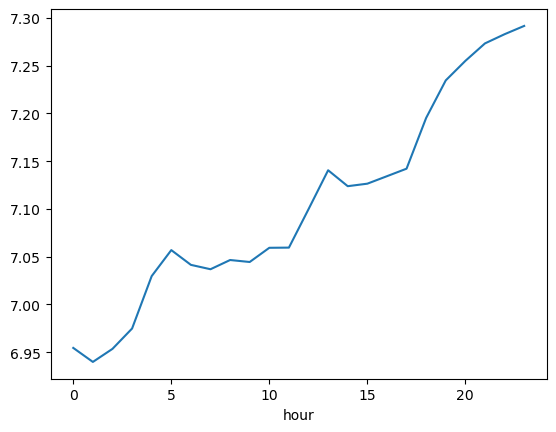

In [5]:
df["perc_dev"].groupby(df["hour"]).mean().plot()
#df["perc_dev"].groupby(df["hour"]).std().plot()

# > standard deviation goes by construction up, since the price is deviating the further it is away from the open price

In [44]:
# index is grouping by day, since a day has 24 hours and the values are spread along 30 days to 24 hours 
df_pivot = df.pivot_table(index=["month","day","minute"], columns='hour', values='perc_dev').dropna()

print(df_pivot.shape)
df_pivot.tail(3)

(488, 24)


hour                     0          1          2          3          4   \
month day minute                                                          
9     30  15      11.436856  11.548423  11.521766  11.518804  11.457919   
          30      11.515842  11.602726  11.469766  11.422704  11.505310   
          45      11.600752  11.549082  11.487209  11.389464  11.522424   

hour                     5          6          7          8          9   ...  \
month day minute                                                         ...   
9     30  15      11.543816  11.458577  11.379920  11.354578  11.390451  ...   
          30      11.459564  11.506956  11.400654  11.422375  11.360502  ...   
          45      11.492475  11.470096  11.430273  11.395388  11.413489  ...   

hour                     14         15         16         17         18  \
month day minute                                                          
9     30  15      11.254529  11.359844  11.404932  11.250580  11.126835   
          30      11.412502  11.413818  11.387489  11.199897  11.052128   
          45      11.386502  11.420400  11.269339  11.195290  11.188708   

hour                     19         20         21         22         23  
month day minute                                                         
9     30  15      11.214707  11.126835  11.140987  11.191670  11.085367  
          30      11.094583  11.077798  11.192328  11.058051  10.952078  
          45      11.105114  11.112354  11.161392  11.102810  10.961623  

[3 rows x 24 columns]

In [46]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=3).fit(df_pivot)

In [47]:
#Create the hour-cluster / term-topic matrix
df_comp = pd.DataFrame(lda.components_.T, index=df_pivot.columns) 

#Normalize it 
norm_components = lda.components_/lda.components_.sum(axis=1).reshape(-1, 1)

df_comp_norm = pd.DataFrame(norm_components.T, index=df_pivot.columns)
df_comp_norm * 100

,0,1,2
hour,,,
0,5.367070,3.598500,2.098661
1,4.879283,4.019618,2.425808
2,5.679901,2.992141,2.352116
3,5.453182,3.322507,2.380986
4,5.066132,3.782617,2.642189
5,4.160361,5.034663,2.703779
6,4.076317,5.096593,2.744257
7,4.540512,4.428677,2.779158
8,4.088371,4.962645,2.940258


To summarise, it seems that there is too little data to have a meaningful clustering of deviation based on the opening price. In essence, there was only one month. 

So, ad hoc, two approaches come to mind: 

 - Use more finegraiend data, like a 1m data or more month. 
 - Divide the open price based percentage deviation into bins (0-0.5;0.5-1;...)

# Bin Approach

22.406172486535368


<Axes: xlabel='perc_dev', ylabel='Count'>

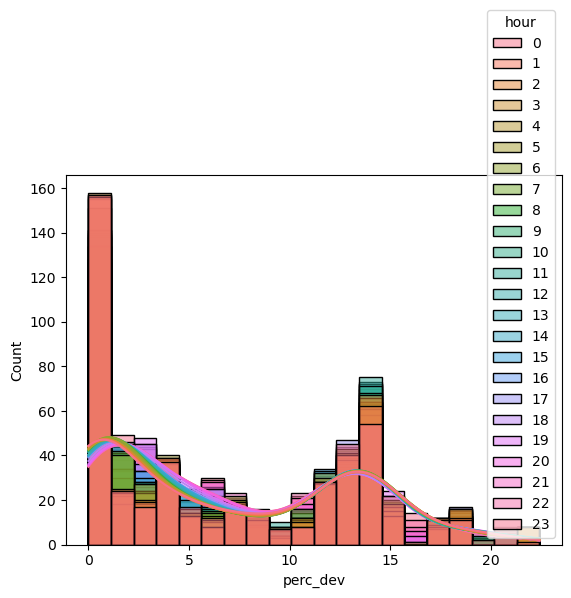

In [61]:
print(max(df["perc_dev"]))
import seaborn as sns
sns.histplot(data=df, x='perc_dev', hue='hour', bins=20, palette='husl', kde=True)

The above figure indicatese that the maximum of the percentage deviation is at 22% and the distribution of can be divided into 3-5 bins. 

Let's try 5 bins. 

In [101]:
df["perc_dev_q5"] = pd.cut(df["perc_dev"],5,labels=[1,2,3,4,5]).values.astype(int)
print(type(df["perc_dev_q5"]))
print(df.shape)
df.head(3)

<class 'pandas.core.series.Series'>
(11716, 17)


,time,open,high,low,close,vol,day,hour,y_m_d_h,daily_open,perc_dev,minute,y_m_d_h_m,y_m_d_m,month,hour_,perc_dev_q5
0,2023-06-01 00:00:00,27103.1,27108.1,27080.6,27096.9,386.675,1,0,2023_6_1_0_0,27103.1,0.022876,0,2023_6_1_0_0,2023_6_1_0,6,0,1
1,2023-06-01 00:15:00,27096.9,27096.9,27036.7,27047.0,408.680,1,0,2023_6_1_0_15,27103.1,0.206987,15,2023_6_1_0_15,2023_6_1_15,6,0,1
2,2023-06-01 00:30:00,27047.0,27077.4,27041.0,27054.9,275.080,1,0,2023_6_1_0_30,27103.1,0.177839,30,2023_6_1_0_30,2023_6_1_30,6,0,1


In [103]:
df_pivot_bin = df.pivot_table(index=["month","day","minute"], columns="hour", values="perc_dev_q5").dropna()

print(df_pivot_bin.shape)
df_pivot_bin.tail(3)

(488, 24)


hour               0    1    2    3    4    5    6    7    8    9   ...   14  \
month day minute                                                    ...        
9     30  15      3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  ...  3.0   
          30      3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  ...  3.0   
          45      3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  ...  3.0   

hour               15   16   17   18   19   20   21   22   23  
month day minute                                               
9     30  15      3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  
          30      3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  
          45      3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  

[3 rows x 24 columns]

In [104]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=3).fit(df_pivot_bin)

#Create the hour-cluster / term-topic matrix
df_comp = pd.DataFrame(lda.components_.T, index=df_pivot.columns) 

#Normalize it 
norm_components = lda.components_/lda.components_.sum(axis=1).reshape(-1, 1)

df_comp_norm = pd.DataFrame(norm_components.T, index=df_pivot.columns)
df_comp_norm * 100

,0,1,2
hour,,,
0,4.152217,4.457873,3.278756
1,4.081393,4.470584,3.485381
2,4.669795,3.627951,3.233185
3,4.389942,4.083610,3.275341
4,4.203136,4.388668,3.320944
5,4.313108,4.162993,3.346370
6,4.321078,4.206096,3.267974
7,4.587563,3.777129,3.246776
8,4.901606,3.158187,3.425880
